In [1]:
from keras.applications import inception_v3
import keras.backend as K
from keras.preprocessing.image import load_img, img_to_array

import matplotlib.pyplot as plt
import sys
import os
import numpy as np
import scipy

Using TensorFlow backend.


In [2]:
#os.listdir("../input/boat-types-recognition/boats/ferry boat")

Load base image and display it. Deep dream will be run on this image.

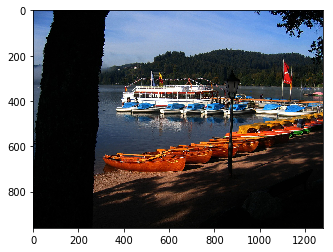

In [3]:
# Load image.

base_image_path = "../input/boat-types-recognition/boats/ferry boat/ferry-boats-dock-port-beach-lake-123648.jpg"
img = img_to_array(load_img(base_image_path), data_format="channels_last")

plt.imshow(img.astype("uint8"))
plt.show()

In [4]:
# Load model.
model = inception_v3.InceptionV3(weights="imagenet", include_top=False)

87916544/87910968 [==============================] - 2s 0us/step


In [5]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

While creating deep dream, output of various layers is used to creat dream illusion. Take few layers and decide their respective contributions in the dream.

In [20]:
layer_contributions = {
    'mixed4': 0.2,
    'mixed5': 0.5,
    #'mixed6': 1.5,
    #'mixed7': 1.5,
}

layer_dict = dict((layer.name, layer) for layer in model.layers)

Loss will be computed as weighted sum of L2 norm of each participating layers output. Since different layers produce outputs with different shapes, outputs with bigger shapes will dominate. To overcome this, loss of each layer is normalized using number of parameters in the output using 'scale' variable.

$$
Loss = \sum_{i=1}^{Num\_output\_layers} \frac {layer\_weight_{i} \times L2(layer_{i}(output))}{\prod layer_{i}(output).shape}
$$

In [21]:
# Compute combined loss for all layers used in contribution. Different layers have different shape so scale loss for each layer by product of shape of that layer.
loss = K.variable(0.)
for name, layer_wt in layer_contributions.items():
    output_ = layer_dict[name].output
    scale = K.prod(K.cast(K.shape(output_[:, 2:-2, 2:-2, :]),"float32"))
    loss += layer_wt * K.sum(K.square(output_)) / scale

In deep dream we don't need to learn any weights. We keep the weights of the model fixed and only make changes to input image. Due to this reason, instead of creating a model, we use K.function(). As it will give output for given input, but will not modify any weights involved. K.function() takes model.input as input (this will be the actual image). Given the input it generates two outputs:

1. Gradient of loss w.r.t. input.

2. Loss of contributing layers.



In [22]:
inputs = model.input

grads = K.gradients(loss, inputs)[0]
# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), K.epsilon())

# Create function that takes image as input and produces gradient and loss as output. As we don't need to learn the weights so we use function, else we should have used Model.
func = K.function(inputs=[inputs], outputs=[grads, loss])

Execute K.function() 'func' for given number of epochs. In each epoch do following:

1. Compute gradient and loss for given input img.

2. Do gradient ascent on input image.

3. Goto step 1.

In [23]:
def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = load_img(image_path)
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def resize_img(img, size):
    img = np.copy(img)
    if K.image_data_format() == 'channels_first':
        factors = (1, 1,
                   float(size[0]) / img.shape[2],
                   float(size[1]) / img.shape[3])
    else:
        factors = (1,
                   float(size[0]) / img.shape[1],
                   float(size[1]) / img.shape[2],
                   1)
    return scipy.ndimage.zoom(img, factors, order=1)

In [10]:
# preprocessed_img = preprocess_image(base_image_path)
# model_input_img = preprocessed_img.copy()
# #print(model_input_img.shape)
# epochs=10
# lr = 0.1
# for i in range(epochs):
#     grads_, loss_ = func([model_input_img])
#     model_input_img += lr * grads_
#     print("{}/{} Loss:{}".format(i+1, epochs, loss_))
#     #plt.imshow(model_input_img[0].astype("uint8"))
#     #plt.show()
# #deprocessed_img = deprocess_image(model_input_img)

# fig = plt.figure(figsize=(10,5))
# plt.subplot(1,2,1)    
# plt.imshow(deprocess_image(preprocessed_img))
# plt.title("Actual Image")

# plt.subplot(1,2,2) 
# plt.imshow(deprocess_image(model_input_img))
# plt.title("Dream Image")
# plt.show()

# img_diff = np.sum(np.square(preprocessed_img - model_input_img))
# print("L2 diff between images:{}".format(img_diff))

Above results are not that good. To produce sharp results we will train different sizes of same image. Use following steps:

1. Make three copies of original image. One of original size (original_img) and one of smallest size (shrunk_img) one on which gradient ascent will be done (img).

2. Start from smallest size.

3. Convert 'img' to current size and run gradient ascent.

4. Convert 'shrunk_img' to current size and 'original_img' to current size and compute difference between them. Intution behind this step is that, when you upscale 'shrunk_img' from previous to current size then some information is lost (blur) is created. While when 'original_img' is down scaled to current size then it will act as baseline for current size. Difference between both tells how much info is lost when 'shrunk_img' is upscaled to current size.

5. Add this difference to 'img'. So basically 'img' is having two updates. First is from gradient ascent (it helps in creating dream). Second is from adding upscaling difference (it will help in increasing sharpness of 'img').

6. Keep repeating above steps for all sizes of images (called octaves).



In [26]:
# Playing with these hyperparameters will also allow you to achieve new effects
lr = 0.05  # Gradient ascent step size
num_octave = 10  # Number of scales at which to run gradient ascent
octave_scale = 1.2  # Size ratio between scales
epochs = 200  # Number of ascent steps per scale
max_loss = 500.

img = preprocess_image(base_image_path)
if K.image_data_format() == 'channels_first':
    original_shape = img.shape[2:]
else:
    original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)
# Sort successive_shape in increasing order.
successive_shapes = successive_shapes[::-1]
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    for i in range(epochs):
        grads_, loss_ = func([img])
        img += lr * grads_
        print("{}/{} Loss:{}".format(i+1, epochs, loss_))
        if loss_ > max_loss:
            break
#     img = gradient_ascent(img,
#                           iterations=iterations,
#                           step=step,
#                           max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)

Processing image shape (666, 888)
1/200 Loss:0.16179189085960388
2/200 Loss:0.19327780604362488
3/200 Loss:0.2569301426410675
4/200 Loss:0.4003192186355591
5/200 Loss:0.6116861701011658
6/200 Loss:0.9930500984191895
7/200 Loss:2.1690292358398438
8/200 Loss:7.34724235534668
9/200 Loss:26.934005737304688
10/200 Loss:81.01182556152344
11/200 Loss:213.61630249023438
12/200 Loss:433.4354248046875
13/200 Loss:812.3787841796875
Processing image shape (800, 1066)
1/200 Loss:380.95440673828125
2/200 Loss:779.86865234375
Processing image shape (960, 1280)
1/200 Loss:680.013916015625


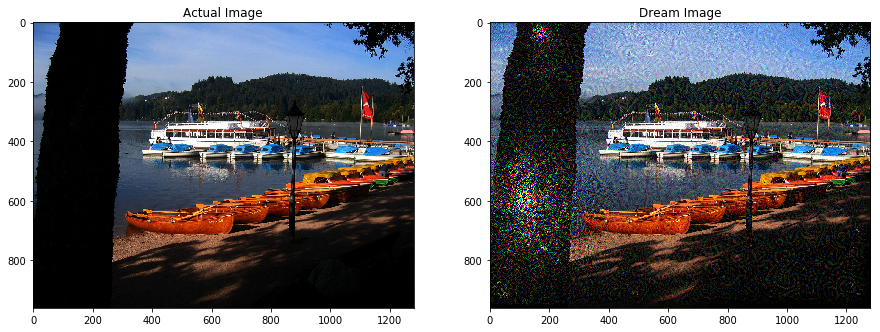

L2 diff between images:15533298.0


In [27]:
fig = plt.figure(figsize=(15,10))
plt.subplot(1,2,1)    
plt.imshow(deprocess_image(original_img.copy()))
plt.title("Actual Image")

plt.subplot(1,2,2) 
plt.imshow(deprocess_image(img.copy()))
plt.title("Dream Image")
plt.show()

img_diff = np.sum(np.square(original_img - img))
print("L2 diff between images:{}".format(img_diff))